In [27]:
%matplotlib inline
import numpy as np
import pandas as pd 
import matplotlib.pylab as plt
from sklearn.metrics import mean_squared_error
import time
np.random.seed(12)

#**Part 1: Data Generation**

Visualization functions

In [31]:
def plot_gp(x_pred, y_pred, sigmas, x_train, y_train, true_y=None, samples=None):
    """
    Function that plots the GP mean & std on top of given points.
    x_pred: points for prediction
    y_pred: means
    sigmas: std
    x, y: given data
    true_y: 
    samples: 2D numpy array with shape (# of points, # of samples)
    """
    if samples is not None:
        plt.plot(all_x.reshape(-1, 1), samples)
    
    plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0, 
                 ecolor=(0.85, 0.85, 0.85), fmt = "r-", 
                 label="pred mean")
    plt.plot(x_train, y_train, "ko", label="training set")
    if true_y is not None:
        plt.plot(x_pred, true_y, "b-", label="truth function")
    plt.legend()

Various generative functions for GP to approximate.

Here we assume that y = 0 when x = 0.

In [32]:
def linear_func(x):
    return 1.2 * x

def sin_wave(x):
    return np.sin(0.9*x).flatten()

Generate train and test data.

In [33]:
x_min = -10
x_max = 10
n_train = 50
generative_func = sin_wave

# X2: we want x in the range of (x_min, x_max)
all_x = np.arange(x_min, x_max, step=0.1)
# Y2: this is the true values of f(x) for x in (x_min, x_max)
# (we are NOT using them to train GP. true_y is only used for evaluation)
true_y = generative_func(all_x)
# X1, Y1: a randomly given training set of: n_train training points
X_train = np.random.uniform(x_min, x_max, n_train)
beta_inv = .01
# noisy data points
y_train = generative_func(X_train)+np.random.randn(len(X_train))*np.sqrt(beta_inv)

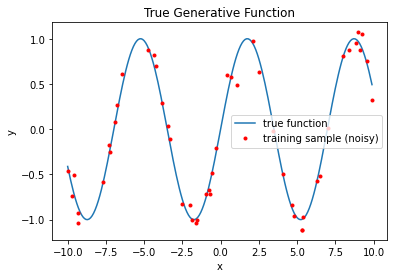

In [34]:
plt.figure()
plt.plot(all_x, true_y, label='true function')
plt.plot(X_train, y_train, '.r', label='training sample (noisy)')
plt.title("True Generative Function")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

In [35]:
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import RBF, Matern, WhiteKernel, ConstantKernel

In [36]:
kernel = ConstantKernel(constant_value=1, constant_value_bounds=(1e-5, 1e5)) + RBF(length_scale=2) + WhiteKernel(noise_level=1)

Text(0.5, 1.0, 'kernel pre-fitting')

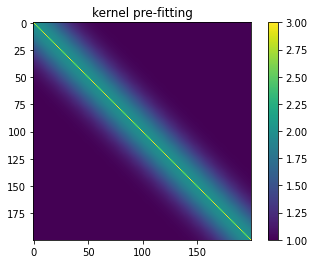

In [37]:
plt.figure()
plt.imshow(kernel(np.array([all_x]).T))
plt.colorbar()
plt.title('kernel pre-fitting')

#### fitting the GP model

The fit() method automatically selects the hyper-parameters of given kernels.

In [38]:
gp = gaussian_process.GaussianProcessRegressor(kernel=kernel)
gp.fit(X_train.reshape(-1,1), y_train.reshape(-1,1))

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


GaussianProcessRegressor(kernel=1**2 + RBF(length_scale=2) + WhiteKernel(noise_level=1))

0.00316**2 + RBF(length_scale=2.02) + WhiteKernel(noise_level=0.011)


Text(0.5, 1.0, 'kernel post-fitting')

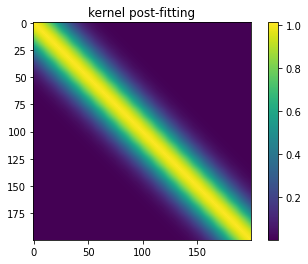

In [39]:
# print the kernel with fitted parameters
print(gp.kernel_)
plt.figure()
plt.imshow(gp.kernel_(np.array([all_x]).T))
plt.colorbar()
plt.title('kernel post-fitting')

prediction of new values

The predict method returns both mean and std.

In [40]:
mus, sigmas = gp.predict(all_x.reshape(-1,1), return_std=True)

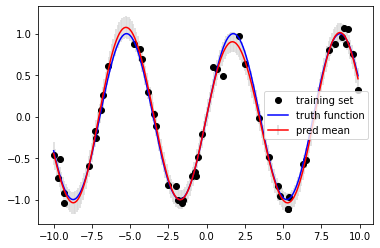

In [41]:
plot_gp(all_x, mus, sigmas, X_train, y_train, true_y=true_y)

In [42]:
def exponential_cov(x, y, params):
    """
    Function that implements the squared exponential kernel
    """
    sigma, l = params
    return np.power(sigma,2) * np.exp( - np.subtract.outer(x, y)**2/(2 * np.power(l,2)))

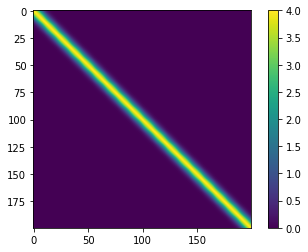

In [43]:
plt.figure()
plt.imshow(exponential_cov(all_x, all_x, (2,.5)))
plt.colorbar()

In [50]:
def predict(x_pred, X_train, y_train, kernel, kernel_params, cholesky=True, beta_inv = 0):
    """
    Top level wrapper function for GP prediction
    """
    if cholesky:
        return predict_cholesky(x_pred, X_train, y_train, kernel, kernel_params, beta_inv)
    else:
        return predict_inverse(x_pred, X_train, y_train, kernel, kernel_params, beta_inv)

def predict_inverse(x_pred, X_train, y_train, kernel, kernel_params, beta_inv):
    """
    GP inference using naive matrix inversion
    x_pred: X1, a numpy vector of size n
    X_train: X2, a numpy vector of size m
    y_train: Y2, a numpy vector of size m
    kernel: a kernel function, should be exponential_cov
    kernel_params: a numpy vector
    @return mu: E[y2]
    @return cov: covariance matrix, a numpy matrix that's n*n 
    """
    C = kernel(X_train, X_train, kernel_params) + np.eye(len(X_train))*beta_inv
    B = kernel(x_pred, X_train, kernel_params)
    C_inv = np.linalg.inv(C)
    A = kernel(x_pred, x_pred, kernel_params) + np.eye(len(x_pred))*beta_inv
    mu = np.dot(B, C_inv).dot(y_train)
    cov = A - np.dot(B, C_inv).dot(B.T)    
    return mu, cov

def predict_cholesky(x_pred, X_train, y_train, kernel, kernel_params, beta_inv):
    """
    GP inference using naive matrix inversion
    x_pred: X1, a numpy vector of size n
    X_train: X2, a numpy vector of size m
    y_train: Y2, a numpy vector of size m
    kernel: a kernel function, should be exponential_cov
    kernel_params: a numpy vector
    @return mu: E[y2]
    @return cov: covariance matrix, a numpy matrix that's n*n 
    """
    ############################################
    ### TODO: please implement this function ###
    ######## (and replace current code) ########
    ############################################
    mu = np.zeros(len(x_pred))
    cov = np.eye(len(x_pred))
    
    K = kernel(x_pred, X_train, kernel_params)
    C_train = kernel(X_train, X_train, kernel_params) + np.eye(len(X_train))*beta_inv
    C_pred = kernel(x_pred, x_pred, kernel_params) + np.eye(len(x_pred)) * beta_inv
    #e = np.random.normal(0, beta_inv)
    t_train = y_train
    L = np.linalg.cholesky(C_train)
    L_inv = np.linalg.inv(L)
    #print(np.dot(L, L.T), C_train)
    #print(np.dot(L, L.T.conj()) == C_train)
    #print(L.shape, K.T.shape, C_train.shape, X_train.shape)
    #print(L,K)
    D1 = np.linalg.solve(L, K.T)
    #print("D1 =",D1)
    D2 = np.linalg.solve(L, t_train)
    #print("D2 =",D2)
    mu = np.dot(D1.T, D2)
    cov = C_pred - np.dot(D1.T, D1)

    return mu, cov

kernel_parameters = [2, 2]

rmse = 0.7216677922512522


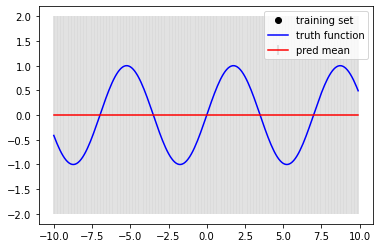

In [54]:
mu_0 = np.zeros(len(all_x))
sigma_0 = np.sqrt(exponential_cov(0, 0, kernel_parameters))
plot_gp(all_x, mu_0, sigma_0, [], [], true_y)
print("rmse = {0}".format(np.sqrt(mean_squared_error(mu_0, true_y))))

Posterior Distribution - single points

Now we start by feeding our GP with a single datum.

In [55]:
cholesky = True

rmse = 0.7225275073327942


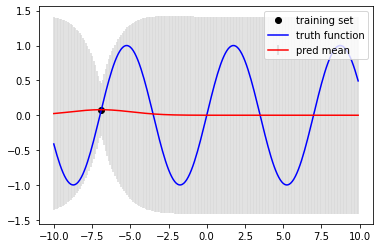

In [57]:
training_data_num = 1
need_X_train = X_train[:training_data_num]
need_y_train = y_train[:training_data_num]
C = exponential_cov(need_X_train, need_X_train, kernel_parameters)
mus, cov = predict(all_x, X_train[:training_data_num], y_train[:training_data_num], exponential_cov, 
                   kernel_parameters, cholesky=cholesky, beta_inv=beta_inv)
sigmas = np.sqrt(np.diag(cov))
plot_gp(all_x, mus, np.sqrt(sigmas), need_X_train, need_y_train, true_y)
print("rmse = {0}".format(np.sqrt(mean_squared_error(mus, true_y))))

rmse = 0.5876302666646062


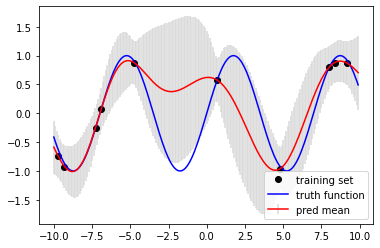

In [59]:
#With 10 points
training_data_num = 10
need_X_train = X_train[:training_data_num]
need_y_train = y_train[:training_data_num]
C = exponential_cov(need_X_train, need_X_train, kernel_parameters)
mus, cov = predict(all_x, X_train[:training_data_num], y_train[:training_data_num], exponential_cov, 
                   kernel_parameters, cholesky=cholesky, beta_inv=beta_inv)
sigmas = np.sqrt(np.diag(cov))
plot_gp(all_x, mus, np.sqrt(sigmas), need_X_train, need_y_train, true_y)
print("rmse = {0}".format(np.sqrt(mean_squared_error(mus, true_y))))

rmse = 0.12489297873814377


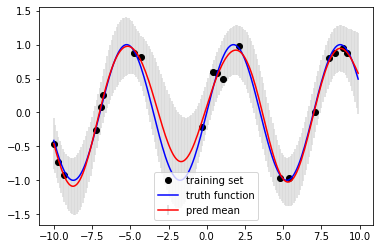

In [60]:
#With 20 points
training_data_num = 20
need_X_train = X_train[:training_data_num]
need_y_train = y_train[:training_data_num]
C = exponential_cov(need_X_train, need_X_train, kernel_parameters)
mus, cov = predict(all_x, X_train[:training_data_num], y_train[:training_data_num], exponential_cov, 
                   kernel_parameters, cholesky=cholesky, beta_inv=beta_inv)
sigmas = np.sqrt(np.diag(cov))
plot_gp(all_x, mus, np.sqrt(sigmas), need_X_train, need_y_train, true_y)
print("rmse = {0}".format(np.sqrt(mean_squared_error(mus, true_y))))

rmse = 0.0575760580566189


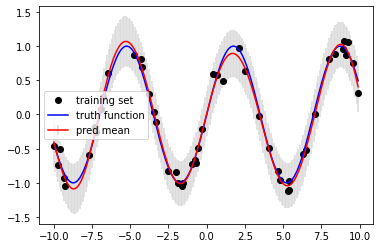

In [61]:
#50 points
training_data_num = 50
need_X_train = X_train[:training_data_num]
need_y_train = y_train[:training_data_num]
mus, cov = predict(all_x, need_X_train, need_y_train, exponential_cov, kernel_parameters, cholesky=cholesky, beta_inv=beta_inv)
sigmas = np.sqrt(np.diag(cov))
plot_gp(all_x, mus, np.sqrt(sigmas), need_X_train, need_y_train, true_y)
print("rmse = {0}".format( np.sqrt(mean_squared_error(mus, true_y))))

#**Part IV: Sampling**
For this part, we implement the sample_cholesky function.

In [71]:
def sample_cholesky(mu, cov, n_points, n_samples):
    """
    Function that performs sampling from  using Cholesky Decomposition
    @param mu: a numpy array of size n
    @param cov: a numpy matrix of size n*n
    @param n_points: how many points per sample
    @param n_samples: how many samples
    @return a numpy matrix with dimension (n_points, n_samples)
    """
    ############################################
    ### TODO: please implement this function ###
    ############################################
    x = np.zeros([n_points, n_samples])
    #x = np.array([])
    z_mean = np.zeros(n_points)
    L = np.linalg.cholesky(cov)
    for i in range(n_samples):
        z = np.random.multivariate_normal(z_mean, np.eye(n_points))
        #print(mu + np.dot(L, z))
        x[:,i] = mu + np.dot(L, z)
        #np.append(x,x_i)
    
    return x

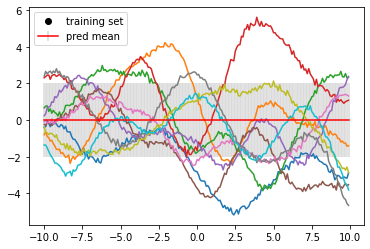

In [72]:
#sample from prior
training_data_num = 0
n_samples = 10
# fix mean and sigmas
mus, cov = predict(all_x, X_train[:training_data_num], y_train[:training_data_num], exponential_cov, 
                   kernel_parameters, cholesky=False, beta_inv=beta_inv)
sigmas = np.sqrt(np.diag(cov))

# sampling - using sample_cholesky
samples = sample_cholesky(mus, cov, len(all_x), n_samples)

# plot samples
plot_gp(all_x, mus, sigmas, X_train[:training_data_num], y_train[:training_data_num], samples=samples)

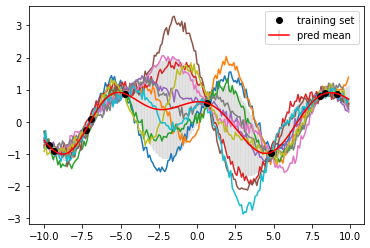

In [73]:
#sample from posterior with 10 points
training_data_num = 10
n_samples = 10
# fix mean and sigmas
mus, cov = predict(all_x, X_train[:training_data_num], y_train[:training_data_num], exponential_cov, kernel_parameters, cholesky=False, beta_inv=beta_inv)
sigmas = np.sqrt(np.diag(cov))

# sampling - using sample_cholesky
samples = sample_cholesky(mus, cov, len(all_x), n_samples)

# plot samples
plot_gp(all_x, mus, sigmas, X_train[:training_data_num], y_train[:training_data_num], samples=samples)

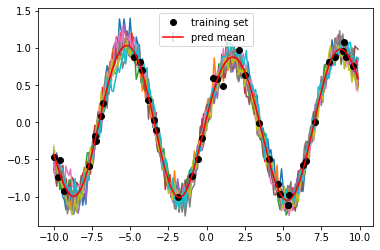

In [74]:
#sample from posterior with 40 points
training_data_num = 40
n_samples = 10
# fix mean and sigmas
mus, cov = predict(all_x, X_train[:training_data_num], y_train[:training_data_num], exponential_cov, 
                   kernel_parameters, cholesky=False, beta_inv=beta_inv)
sigmas = np.sqrt(np.diag(cov))

# sampling - using sample_cholesky
samples = sample_cholesky(mus, cov, len(all_x), n_samples)

# plot samples
plot_gp(all_x, mus, sigmas, X_train[:training_data_num], y_train[:training_data_num], samples=samples)

What if observation noise is assumed to be 0
(this part is not graded)

In [76]:
training_data_num = 10
n_samples = 10
# fix mean and sigmas
mus, cov = predict(all_x, X_train[:training_data_num], y_train[:training_data_num], exponential_cov, 
                   kernel_parameters, cholesky=False, beta_inv=0)
sigmas = np.sqrt(np.diag(cov))

# sampling - using sample_cholesky
samples = sample_cholesky(mus, cov, len(all_x), n_samples)

# plot samples
plot_gp(all_x, mus, sigmas, X_train[:training_data_num], y_train[:training_data_num], samples=samples)

LinAlgError: ignored